# Market Basket Analysis

Market Basket Analysis é uma das principais técnicas usadas por grandes varejistas para descobrir associações entre itens.

A técnica funciona procurando combinações de itens que ocorrem juntos com frequência nas transações. Em outras palavras, permite que os varejistas identifiquem as relações entre os itens que as pessoas compram.


In [1]:
!pip install -q efficient_apriori

In [2]:
# Importando os Pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori

## Carregando os dados

In [3]:
# Carrega os dados
aisle = pd.read_csv('dados/aisles.csv')
department = pd.read_csv('dados/departments.csv')
order = pd.read_csv('dados/orders.csv')
product = pd.read_csv('dados/products.csv')
order_product_prior = pd.read_csv('dados/order_products__prior.csv')
order_product_train = pd.read_csv('dados/order_products__train.csv')

## Análise Exploratória

In [4]:
# Total de registros por dataset
registros = np.array([['aisle', len(aisle)],
                     ['department', len(department)],
                     ['order', len(order)],
                     ['product', len(product)],
                     ['order_product_prior', len(order_product_prior)],
                     ['order_product_train', len(order_product_train)]])
observacoes = pd.DataFrame(registros, columns = ['Arquivo', 'Total_de_registros'])
observacoes

,Arquivo,Total_de_registros
0,aisle,134
1,department,21
2,order,3421083
3,product,49688
4,order_product_prior,32434489
5,order_product_train,1384617


In [5]:
# Itens na categoria de eval_set
order['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [6]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## Limpeza dos Dados

In [7]:
print('Valores ausentes no conjunto de dados aisle:', aisle.isnull().sum())
print('Valores ausentes no conjunto de dados department:', department.isnull().sum())
print('Valores ausentes no conjunto de dados order:', order.isnull().sum())
print('Valores ausentes no conjunto de dados product:', product.isnull().sum())
print('Valores ausentes no conjunto de dados order_product_prior:', order_product_prior.isnull().sum())
print('Valores ausentes no conjunto de dados order_product_train:', order_product_train.isnull().sum())

Valores ausentes no conjunto de dados aisle: aisle_id    0
aisle       0
dtype: int64
Valores ausentes no conjunto de dados department: department_id    0
department       0
dtype: int64
Valores ausentes no conjunto de dados order: order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
Valores ausentes no conjunto de dados product: product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
Valores ausentes no conjunto de dados order_product_prior: order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
Valores ausentes no conjunto de dados order_product_train: order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


## Feature Extraction

### Merge da Tabela order_product_prior com order, product, aisle e department


In [8]:
# Merge, igual fazer um join em SQL
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

In [9]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [10]:
# Análisando os valores ausentes depois da concatenação
order_product_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [11]:
# Percentual de valores ausentes 
order_product_prior.isna().sum() / len(order_product_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos manter a variável days_since_prior_order por duas razões:

1- O percentual de valores ausentes é apenas de 6.4%.

2- Não usaremos a variável com o algoritmo MBA.

### Merge da Tabela order_product_train com order, product, aisle e department

In [12]:
# Merge, igual fazer um join em SQL
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

In [13]:
order_product_train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,water seltzer sparkling water,beverages


In [14]:
order_product_train.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

> Vamos agrupar os dados para aplicar o algoritmo Apriori e preparar o dataset com todas as transações

In [57]:
# Agrupamento
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

In [58]:
order_grouped.shape

(3214874, 2)

In [59]:
len(order_grouped[0])

3214874

In [60]:
order_grouped.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [61]:
# Lista de Produtos 
produtos = []

In [62]:
for i in range(len(order_grouped[0])):
    produtos.append(list(order_grouped.iloc[i][1]))

In [63]:
prod = produtos

In [64]:
order1 = order_grouped[0]

In [65]:
# Preparando o DataFrame e transactions para o apriori

transactions = pd.DataFrame({'OlderID': order1, 'Products': prod})
transactions.head(10)

,OlderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


## Análise Estatística Descritiva

1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [15]:
# Agrupa os dados por usuário e número do pedido, agregando pelo maior valor
ord_max_count = order.groupby('user_id')['order_number'].agg(np.max).reset_index()
ord_max_count.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [16]:
# Faz a contagem no número de pedidos:
ord_max_count = ord_max_count.order_number.value_counts()
ord_max_count.head(10)

4     23986
5     19590
6     16165
7     13850
8     11700
9     10190
10     9032
11     7815
12     6952
13     6236
Name: order_number, dtype: int64

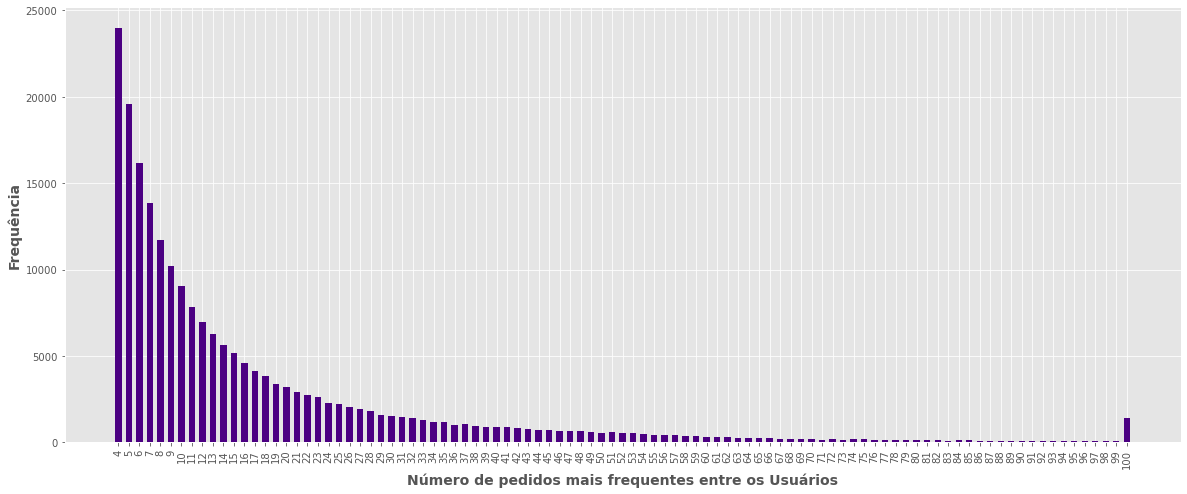

In [17]:
# Preparando o Plot
plt.style.use('ggplot')
plt.figure(figsize = (20, 8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de pedidos mais frequentes entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [18]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

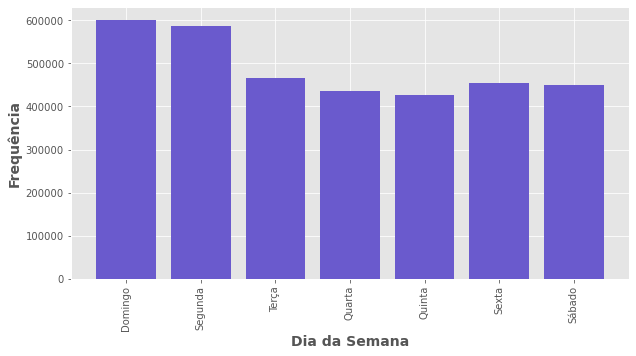

In [19]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [55]:
# Frequências de pedidos pela hora do dia
#x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
#y = [order[order['order_hour_of_day']==0].shape[0], order[order['order_hour_of_day']==1].shape[0], order[order['order_hour_of_day']==2].shape[0], order[order['order_hour_of_day']==3].shape[0], order[order['order_hour_of_day']==4].shape[0], order[order['order_hour_of_day']==5].shape[0], order[order['order_hour_of_day']==6].shape[0], order[order['order_hour_of_day']==7].shape[0], order[order['order_hour_of_day']==8].shape[0], order[order['order_hour_of_day']==9].shape[0], order[order['order_hour_of_day']==10].shape[0], order[order['order_hour_of_day']==11].shape[0], order[order['order_hour_of_day']==12].shape[0], order[order['order_hour_of_day']==13].shape[0], order[order['order_hour_of_day']==14].shape[0], order[order['order_hour_of_day']==15].shape[0], order[order['order_hour_of_day']==16].shape[0], order[order['order_hour_of_day']==17].shape[0], order[order['order_hour_of_day']==18].shape[0], order[order['order_hour_of_day']==19].shape[0] order[order['order_hour_of_day']==20].shape[0], order[order['order_hour_of_day']==21].shape[0], order[order['order_hour_of_day']==22].shape[0], order[order['order_hour_of_day']==23].shape[0]]
# Código com for:
x = list(range(24))
y = []

for hour in x:
    y.append(order[order['order_hour_of_day'] == hour].shape[0])

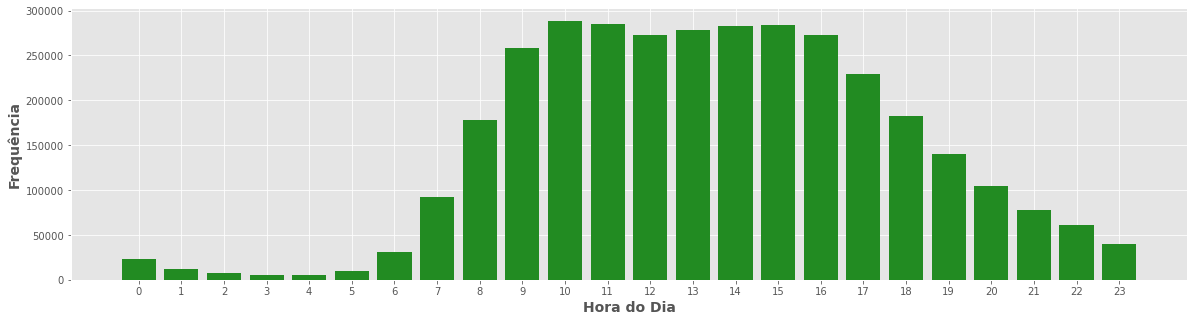

In [56]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

 4- Qual Departamento Tem o Maior Número de Pedidos?

In [22]:
# Contagem de pedidos por departamento
dept_cont = order_product_prior['department'].value_counts()

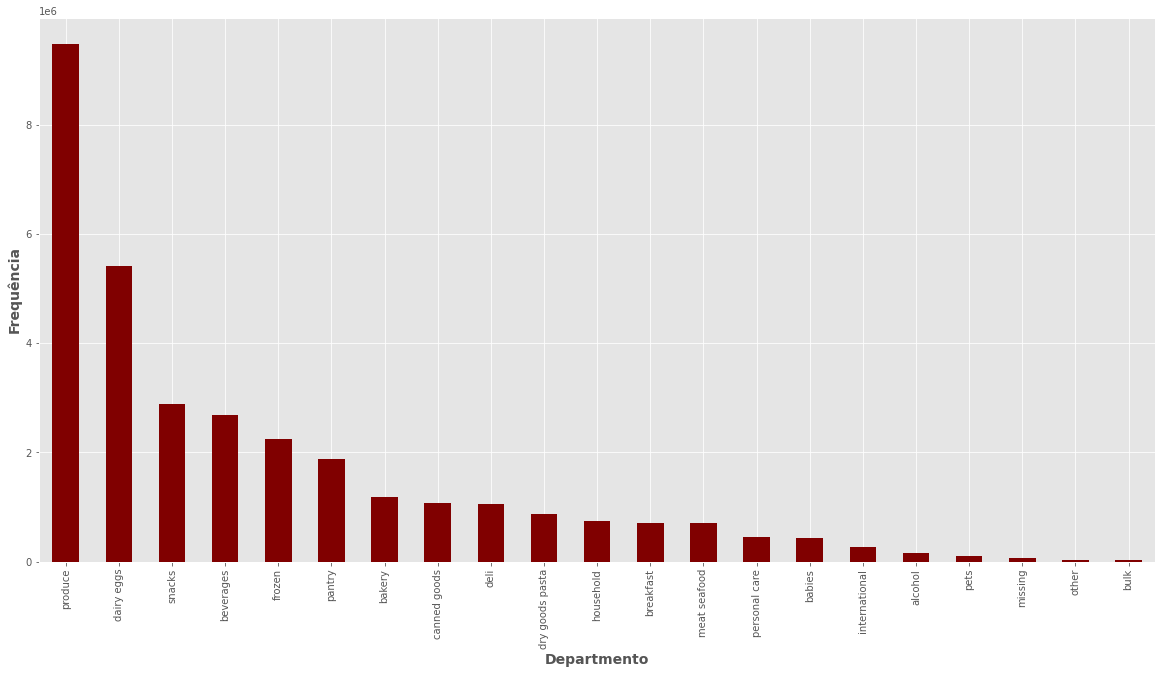

In [23]:
# Plot
fig = plt.figure(figsize = (20,10))
dept_cont.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [24]:
# Os 20 principais corredores e sua frequência de pedidos
aisle_cnt = order_product_prior['aisle'].value_counts()

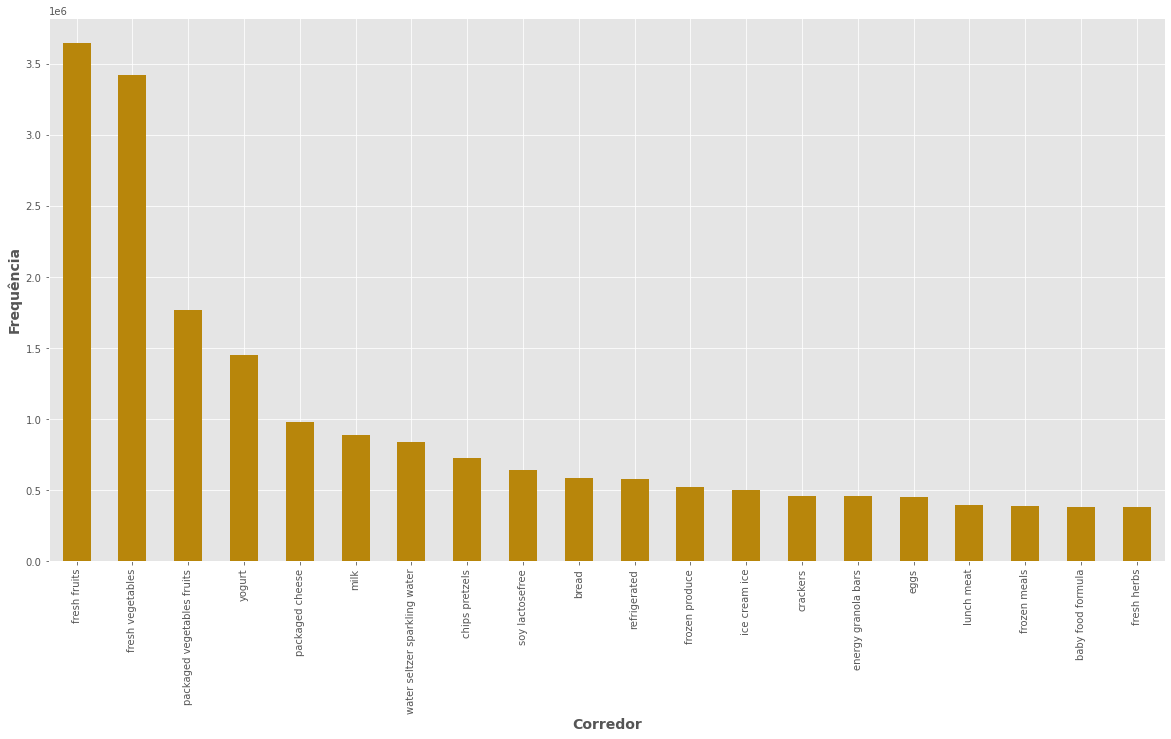

In [25]:
# Plot, aisle_cnt[0:20]- tecnica de fatiamento para pegar os 20 principais corredores.
fig = plt.figure(figsize = (20,10))
aisle_cnt[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [26]:
# Os 20 principais produtos por frequência de pedido
prod_cnt = order_product_prior['product_name'].value_counts()

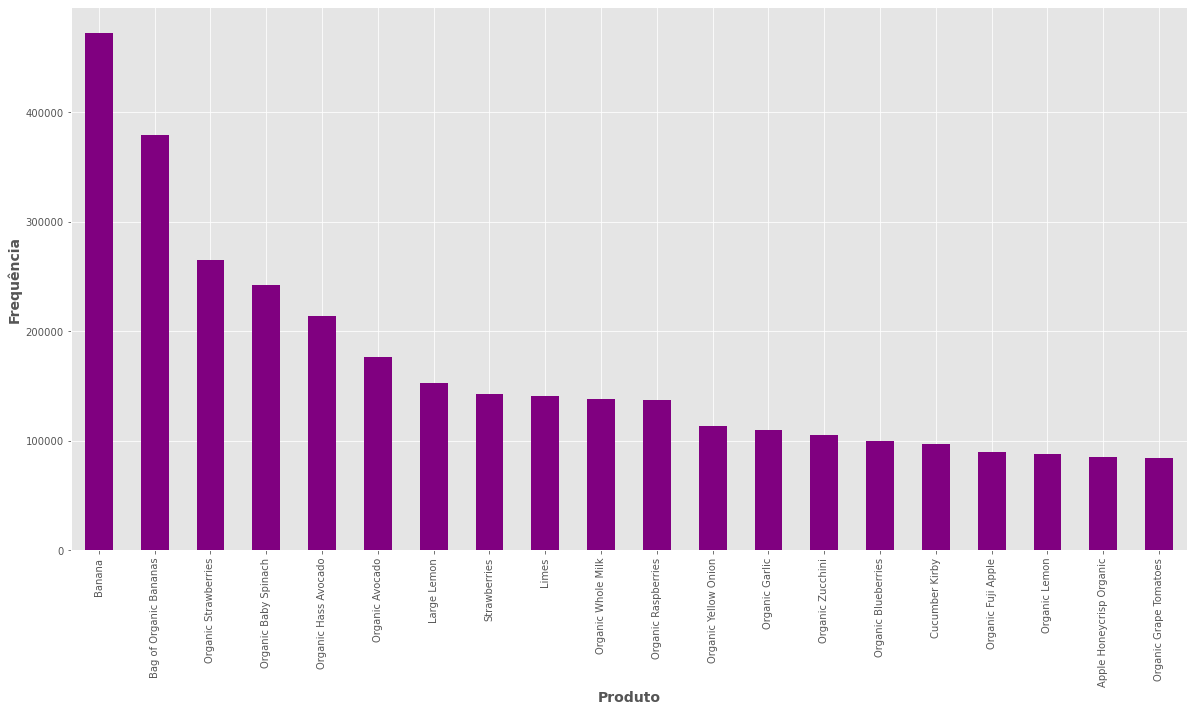

In [28]:
# Plot, prod_cnt[0:20]- tecnica de fatiamento para pegar os 20 principais produtos.
fig = plt.figure(figsize = (20,10))
prod_cnt[0:20].plot(kind = "bar", color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

In [34]:
temp_df = order_product_prior.groupby('product_name')['reordered'].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [35]:
# Prepara as listas
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])    

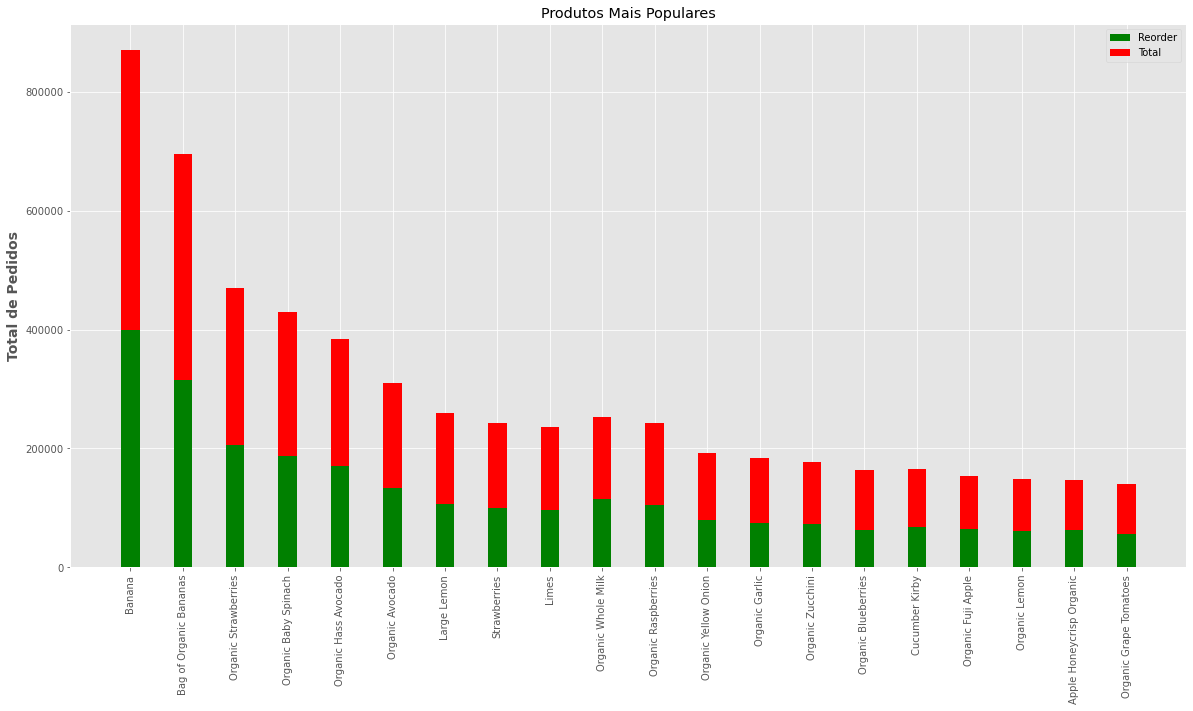

In [36]:
# Plot  
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 90)
plt.show()

7- Análise de Reorder Por Departamento ao Longo do Tempo

In [37]:
# Agrupando os dados por departamento e reorder
grouped_df = order_product_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


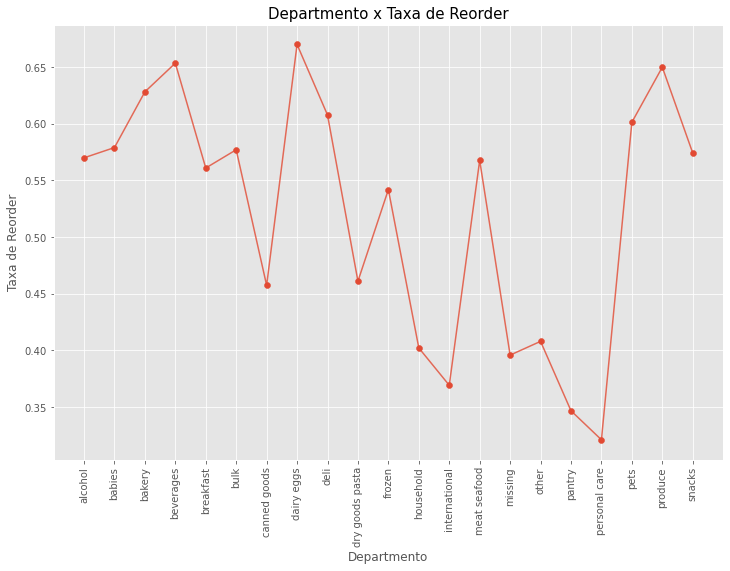

In [38]:
# Plot
plt.figure(figsize = (12,8))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

8- Análise de Reorder e Pedidos

In [39]:
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [40]:
# Listas
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

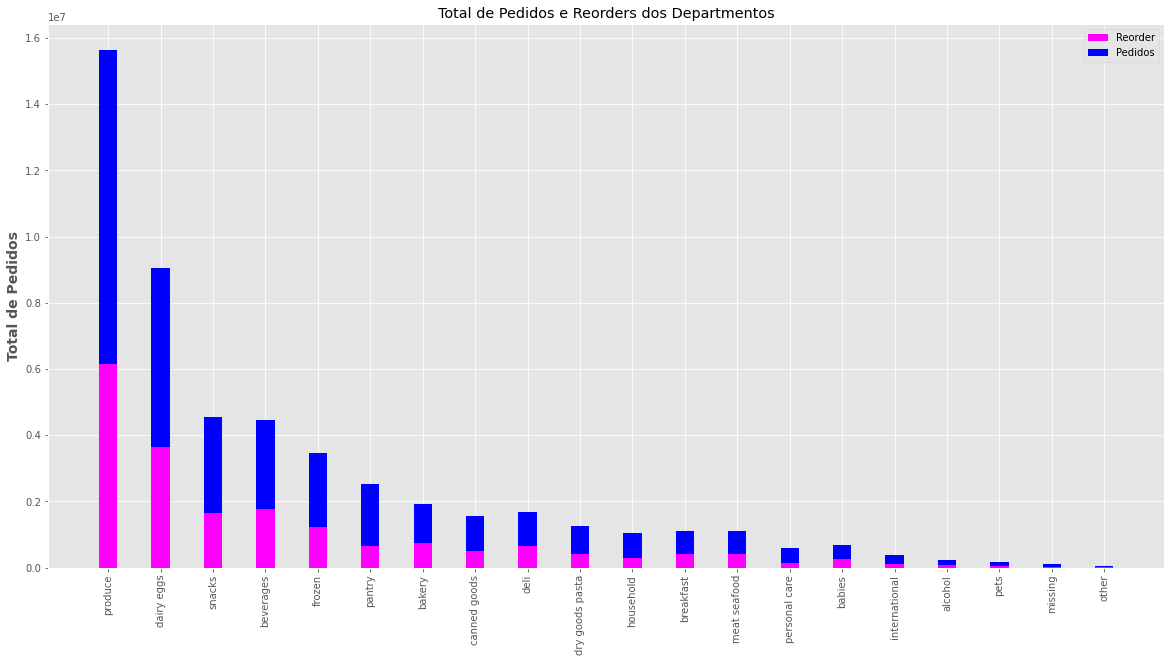

In [41]:
# Plot
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 90)
plt.show()

- Pessoas tendêm a repedir o padrão! Nesse caso de compras.

9- Análise de Reorder Por Corredor

In [42]:
grouped_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [43]:
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

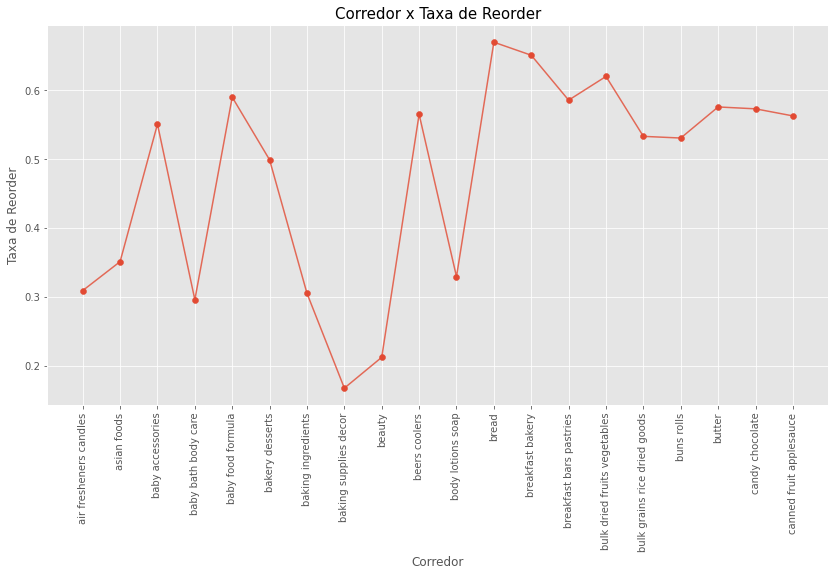

In [44]:
# Corredor x Taxa de Reorder
plt.figure(figsize=(14,7))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

10- Análise de Reorder Por Corredor (Total)

In [45]:
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [46]:
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [47]:
# Listas
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

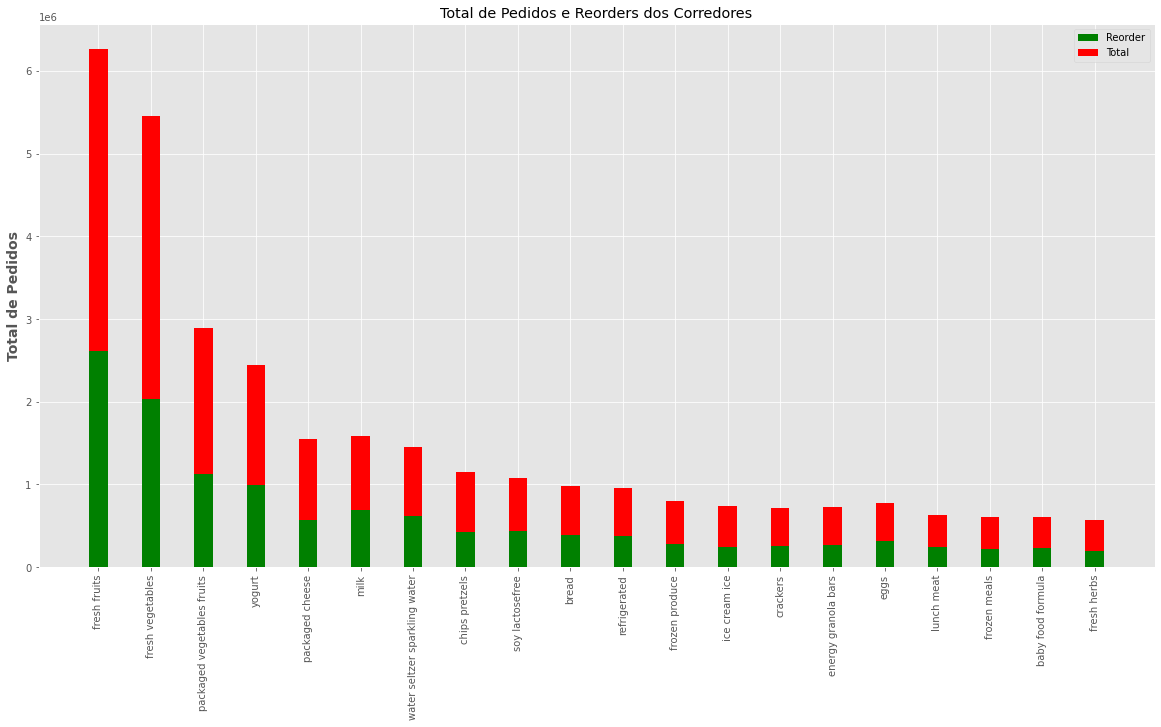

In [48]:
# Plot
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()

* Observado que claramente há um padrão de compra dos usuários.

11 - Verificando a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [51]:
order_product_prior["add_to_cart_order_mod"] = order_product_prior["add_to_cart_order"].copy()
order_product_prior["add_to_cart_order_mod"].loc[order_product_prior["add_to_cart_order_mod"] > 70] = 70
grouped_df = order_product_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

C:\Users\joaoe\AppData\Local\Temp\ipykernel_12876\84629546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_product_prior["add_to_cart_order_mod"].loc[order_product_prior["add_to_cart_order_mod"] > 70] = 70


In [54]:
grouped_df.head(10)

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
5,6,0.600420
6,7,0.585687
7,8,0.573247
8,9,0.561474
9,10,0.551018


## Algoritmo Apriori

In [66]:
# Prepara a tupla com as transações
transactions_tup = []
products_list = transactions['Products'].tolist()

for row in products_list:
    transactions_tup.append(tuple(row))

### Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

In [67]:
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)

In [68]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [69]:
itemsets_ap

{1: {(28985,): 10521,
  (17794,): 11438,
  (24838,): 7699,
  (21903,): 37500,
  (46667,): 8174,
  (13176,): 58901,
  (27966,): 21167,
  (23909,): 5828,
  (47209,): 33109,
  (31506,): 7734,
  (24852,): 73597,
  (31717,): 10667,
  (47766,): 27282,
  (4605,): 11407,
  (21137,): 41275,
  (27156,): 5997,
  (49235,): 12008,
  (196,): 5636,
  (33198,): 6587,
  (27845,): 21360,
  (20995,): 5209,
  (45066,): 12387,
  (19660,): 8799,
  (34969,): 8271,
  (44632,): 11876,
  (46979,): 10362,
  (42265,): 11936,
  (8518,): 10369,
  (35951,): 8955,
  (25890,): 7782,
  (21938,): 8432,
  (40604,): 5023,
  (41950,): 10020,
  (22825,): 7716,
  (47626,): 23859,
  (43352,): 9010,
  (22935,): 17653,
  (4920,): 13027,
  (49683,): 15109,
  (28199,): 6252,
  (48679,): 7953,
  (28204,): 13971,
  (27344,): 6499,
  (33000,): 5274,
  (5077,): 9546,
  (16797,): 22248,
  (39275,): 15594,
  (4799,): 5732,
  (37646,): 11317,
  (40706,): 13146,
  (5876,): 13621,
  (42736,): 5537,
  (30391,): 12528,
  (11520,): 6207,
  (

In [71]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [72]:
#Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [73]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [74]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [75]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [76]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


In [77]:
df_rules_ap.sort_values(by = 'Support_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
2,Organic Strawberries,Banana,0.082550,0.147194,0.017596,0.213156,1.448127
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554


### Conclusão
Aplicando Matemática e Estatística via programação executamos uma análise de MBA gerando como resultado as regras de associação entre os produtos com diferentes métricas. Podemos agora levar nossas conclusões aos tomadores de decisão e partir para o próximo projeto.